In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ase import units
import glob
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/apdft-ofdft-cpmd/')
import profess_io as pio
import analyse_MD as aMD

In [70]:
def sort_dat_files(list_of_files):
    sorted_index = []
    for i in list_of_files:
        sorted_index.append((float(i.split('.')[-2]), i))
    sorted_index.sort(key=lambda tup: tup[0])  # sorts in place
    data_sorted = []
    for item in sorted_index:
        data_sorted.append(item[1])
    return(data_sorted)

def plot_energy(time, energy, energy_label):
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(1,1)
    ax.plot(time[0][:500], energy[0][:500], label=r'dt=0.1, tol = $10^{-5}$')
    ax.plot(time[1],energy[1], label='dt=0.01, tol = $10^{-5}$')
    ax.plot(time[2], energy[2], label='dt=0.001, tol = $10^{-5}$')
    ax.plot(time[3], energy[3], label='dt=0.1, tol = $10^{-6}$')
    ax.plot(time[4], energy[4], label='dt=0.1, tol = $10^{-8}$')
    ax.plot(time[5][:1000], energy[5][:1000], label='restarted dt=0.1, tol = $10^{-8}$')
    ax.plot(time[6], energy[6], label='dt=0.1, tol = $10^{-10}$')
    ax.plot(time[7], energy[7], label='dt=0.1, tol = $10^{-12}$')
    ax.plot(time[8], energy[8], label='dt=0.01, tol = $10^{-6}$')
    # ax.plot(time[3][:500], etot[3][:500], label='restart')

    ax.set_xlabel('t (fs)')
    ax.set_ylabel(energy_label)

    # for t, v, l in zip(time, epot, labels):
    #     ax.plot(t,v, label = l)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return(fig, ax)
def drift(time, energy, tstart=None, tend=None):
    if tstart == None and tend == None:
        dE = (energy[-1]-energy[0])/time[-1]/units.Ha*1000
    else:
        dE = (energy[tend]-energy[tstart])/(time[tend] - time[tstart])/units.Ha*1000

    return(dE)

### Initial NVE run

In [74]:
original = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
epot = np.array(pio.parse_out_file(original, 'NVE Potential energy'))*units.Ha
ekin = np.array(pio.parse_out_file(original, 'NVE Kinetic energy'))*units.Ha
etot = epot + ekin
temp = np.array(pio.parse_out_file(original, 'nve temperature'))

dt = 0.1
time = np.arange(0, len(epot)*dt, dt)

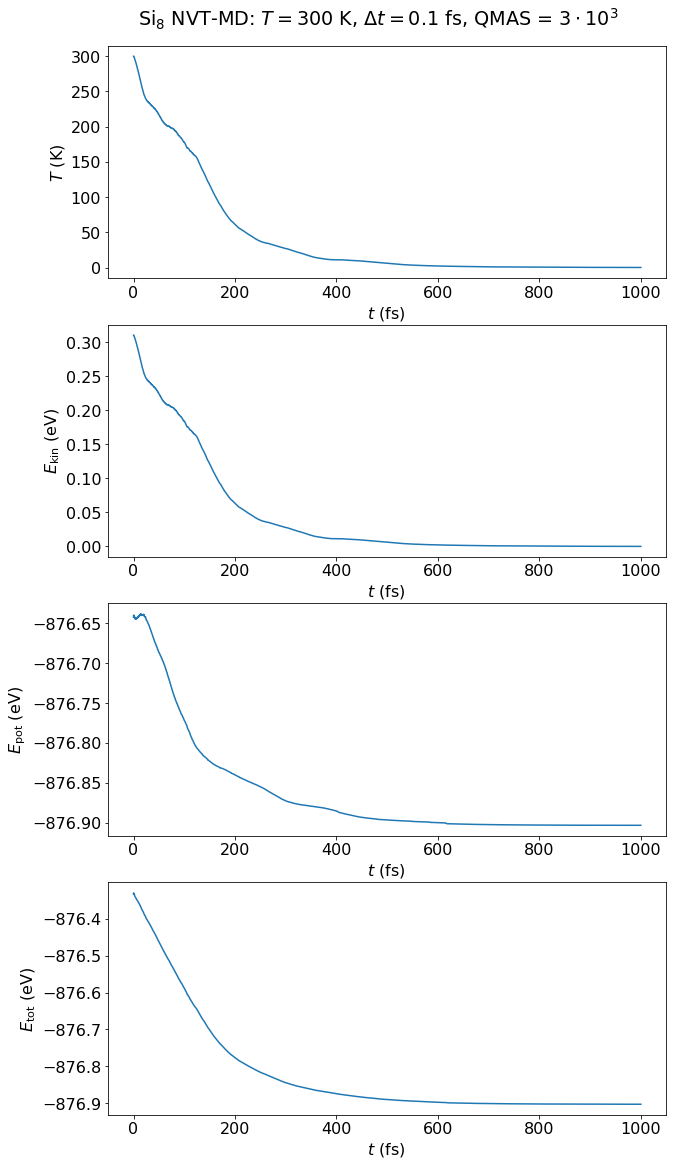

In [80]:
plt.rcParams['figure.figsize'] = [10,18]
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(4,1)
ax[0].plot(time[:10000],temp[:10000])
ax[1].plot(time[:10000],ekin[:10000])
ax[2].plot(time[:10000], epot[:10000])
ax[3].plot(time[:10000], etot[:10000])

ylabel = [r'$T$ (K)', r'$E_{\rm{kin}}$ (eV)', r'$E_{\rm{pot}}$ (eV)', r'$E_{\rm{tot}}$ (eV)']
for i in range(4):
    ax[i].set_xlabel(r'$t$ (fs) ')
    ax[i].set_ylabel(ylabel[i])
fig.subplots_adjust(top=0.95)
fig.suptitle(r'Si$_8$ NVT-MD: $T = 300$ K, $\Delta t = 0.1$ fs, QMAS = $3 \cdot 10^3$')
fig.savefig('/home/misa/projects/APDFT-CPMD/figures/BOMD/Si8_NVE_300K_dt_0.1_tol_1e-5.png', bbox_inches='tight')

In [27]:
original = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
pdt = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_dt/nve_Si8.out'
pddt = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ddt/nve_Si8_complete.out'
ptol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_tol/nve_Si8.out'
pttol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol/nve_Si8.out'
pttol_long = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol_long/nve_Si8.out'
ptol10 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol10/nve_Si8.out'
ptol12 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol12/nve_Si8.out'
pdt_tol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_dt_tol/nve_Si8.out'
# out_restart = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_restart/nve_Si8.out'

epot = []
ekin = []
etot = []
for p in [original, pdt, pddt, ptol, pttol, pttol_long, ptol10, ptol12, pdt_tol]:
    epot_tmp = np.array(pio.parse_out_file(p, 'NVE Potential energy'))*units.Ha
    ekin_tmp = np.array(pio.parse_out_file(p, 'NVE Kinetic energy'))*units.Ha
    etot_tmp = epot_tmp + ekin_tmp
    
    epot.append(epot_tmp)
    ekin.append(ekin_tmp)
    etot.append(etot_tmp)

# '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_restart/nve_Si8.out'
time = []
for i, dt in enumerate([0.1, 0.01, 0.001, 0.1, 0.1, 0.1, 0.1, 0.1, 0.01]):
    time.append(np.arange(0, len(epot[i])*dt, dt))

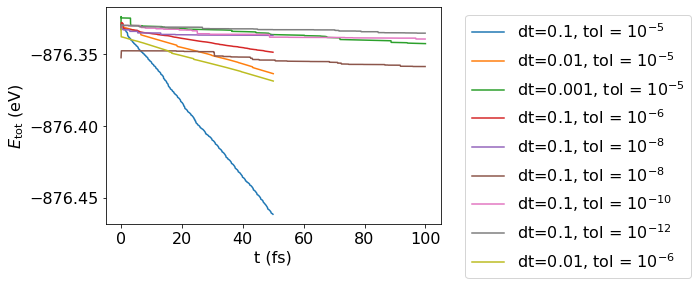

In [41]:
fig, ax = plot_energy(time, etot, r'$E_{\rm{tot}}$ (eV)')

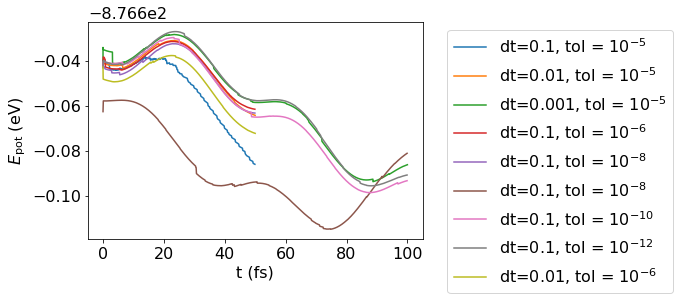

In [42]:
fig, ax = plot_energy(time, epot, r'$E_{\rm{pot}}$ (eV)')

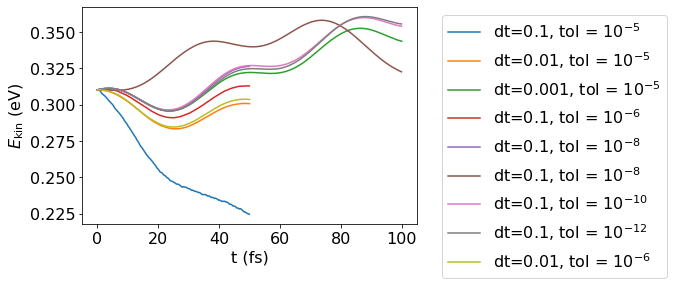

In [43]:
fig, ax = plot_energy(time, ekin, r'$E_{\rm{kin}}$ (eV)')

In [44]:
for i in range(len(etot)):
    print(drift(time[i], etot[i]))

-0.002698644620421625
-0.023135500407715896
-0.00387722440801292
-0.011824380960966156
-0.003045351415345751
-0.002032265315789019
-0.0024506486861599645
-0.0009468790216476703
-0.02654546214852931


### Compare tolerance

In [47]:
original = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/nve_Si8.out'
ptol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_tol/nve_Si8.out'
# pttol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol/nve_Si8.out'
pttol_long = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol_long/nve_Si8.out'
ptol10 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol10/nve_Si8.out'
ptol12 = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_tol12/nve_Si8.out'

In [48]:
epot = []
ekin = []
etot = []
for p in [original, ptol, pttol_long, ptol10, ptol12]:
    epot_tmp = np.array(pio.parse_out_file(p, 'NVE Potential energy'))*units.Ha
    ekin_tmp = np.array(pio.parse_out_file(p, 'NVE Kinetic energy'))*units.Ha
    etot_tmp = epot_tmp + ekin_tmp
    
    epot.append(epot_tmp)
    ekin.append(ekin_tmp)
    etot.append(etot_tmp)

# '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_restart/nve_Si8.out'
time = []
for i, dt in enumerate([0.1, 0.1, 0.1, 0.1, 0.1]):
    time.append(np.arange(0, len(epot[i])*dt, dt))

In [57]:
def plot_e_tol(time, energy, energy_label):
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(1,1)
#     ax.plot(time[0][:1000], energy[0][:1000], label=r'tol = $10^{-5}$')
    ax.plot(time[1],energy[1], label='tol = $10^{-6}$')
    ax.plot(time[2][:1000], energy[2][:1000], label='tol = $10^{-8}$')
    ax.plot(time[3], energy[3], label='tol = $10^{-10}$')
    ax.plot(time[4], energy[4], label='tol = $10^{-12}$')

    # ax.plot(time[3][:500], etot[3][:500], label='restart')

    ax.set_xlabel('t (fs)')
    ax.set_ylabel(energy_label)

    # for t, v, l in zip(time, epot, labels):
    #     ax.plot(t,v, label = l)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

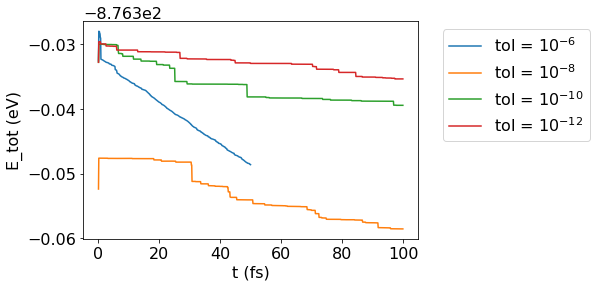

In [58]:
plot_e_tol(time, etot, 'E_tot (eV)')

In [62]:
(etot[4][-1]-etot[4][0])/8*10/units.Ha

-0.00011824151782825283

In [ ]:
- systematic improvement with decreasing threshold
- periods with almost constant energy with sudden jumps
- jumps could be the reason for loss of energy


### Restart NVE after 50 fs equilibration

In [63]:
pttol = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol/nve_Si8.out'
pttol_long = '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_ttol_long/nve_Si8.out'

In [64]:
epot = []
ekin = []
etot = []
for p in [pttol, pttol_long]:
    epot_tmp = np.array(pio.parse_out_file(p, 'NVE Potential energy'))*units.Ha
    ekin_tmp = np.array(pio.parse_out_file(p, 'NVE Kinetic energy'))*units.Ha
    etot_tmp = epot_tmp + ekin_tmp
    
    epot.append(epot_tmp)
    ekin.append(ekin_tmp)
    etot.append(etot_tmp)

# '/home/misa/projects/APDFT-CPMD/data/BOMD/NVE_trouble/Si8_hc_restart/nve_Si8.out'
time = []
for i, dt in enumerate([0.1, 0.1]):
    time.append(np.arange(0, len(epot[i])*dt, dt))

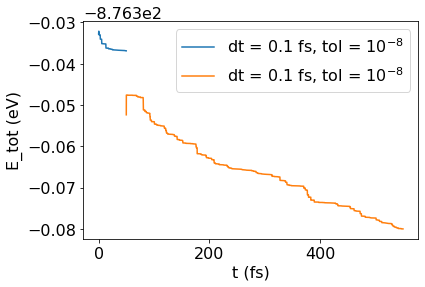

In [67]:
plt.plot(time[0], etot[0],'-', label = r'dt = 0.1 fs, tol = $10^{-8}$')
plt.plot(time[1]+50, etot[1],'-', label = r'dt = 0.1 fs, tol = $10^{-8}$')
plt.xlabel('t (fs)')
plt.ylabel('E_tot (eV)')
plt.legend()

In [ ]:
my hope was that after initial equilibration jumps stop
to test this I run a MD simulation with tol = 10^-8 for 50 fs and used the last structure as starting structure for a new longer MD run
but there is a huge jump in total energy and and the energy decrease rather rapidly after being constant in the beginning
However, it is encouraging that the simulation is more stable than the intial one with tol=10^-5
The kinetic energy does not decay continously but oscillates with a relative phase shift of almost 180° to the potential energy

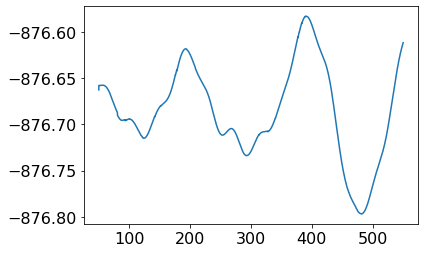

In [68]:
plt.plot(time[1]+50, epot[1],'-', label = r'dt = 0.1 fs, tol = $10^{-8}$')

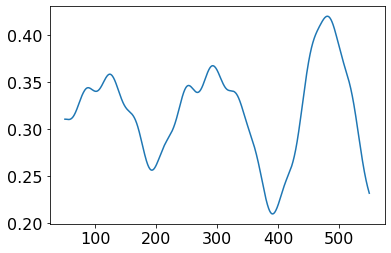

In [69]:
plt.plot(time[1]+50, ekin[1],'-', label = r'dt = 0.1 fs, tol = $10^{-8}$')

In [ ]:
ion_data=glob.glob('/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVE_ref/ion.*.dat')
ion_data = sort_dat_files(ion_data)
positions = aMD.get_positions2(ion_data)

In [ ]:
50e-15/1e-17

In [ ]:
plt.rcParams['figure.figsize'] = [10,20]
fig, ax = plt.subplots(3,1)
for i in range(3):
    aMD.plot_coordinate(ax, i, positions, i)